# Localize Defect Febric Image Segemntation

## Importing Dependencies

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import normalize

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [22]:
img_path = "/home/robin/assignment Folder/defect Febric detection/image/"
mask_path = "/home/robin/assignment Folder/defect Febric detection/masks/"

In [23]:
SIZE = 256

train_img_data = []

train_mask_data = []

In [24]:
train_images = os.listdir(img_path)

sorted_train_images = sorted(train_images)

sorted_train_images[:5]

['Fabric1.jpg', 'Fabric10.jpg', 'Fabric11.jpg', 'Fabric12.jpg', 'Fabric13.jpg']

In [25]:
len(sorted_train_images)

24

In [26]:
# For Images

for i, image_name in enumerate(sorted_train_images):    
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(img_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_img_data.append(np.array(image))

In [27]:
# for training masks

train_masks = os.listdir(mask_path)

sorted_train_masks = sorted(train_masks)

sorted_train_masks[:5]

['Fabric10_defectFebric.tiff',
 'Fabric11_defectFebric.tiff',
 'Fabric12_defectFebric.tiff',
 'Fabric13_defectFebric.tiff',
 'Fabric14_defectFebric.tiff']

In [28]:
len(sorted_train_masks)

24

In [29]:
for i, image_name in enumerate(sorted_train_masks):
    if (image_name.split('.')[1] == 'tiff'):
        image = cv2.imread(mask_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_data.append(np.array(image))

In [30]:
# Normalize images

train_img_data = np.expand_dims(normalize(np.array(train_img_data), axis=1),3)

In [31]:
# rescale mask to 0 to 1.

train_mask_data = np.expand_dims((np.array(train_mask_data)),3) /255.

In [32]:
X_train,X_test,y_train,y_test =train_test_split(train_img_data, train_mask_data,test_size = 0.20,random_state =0)

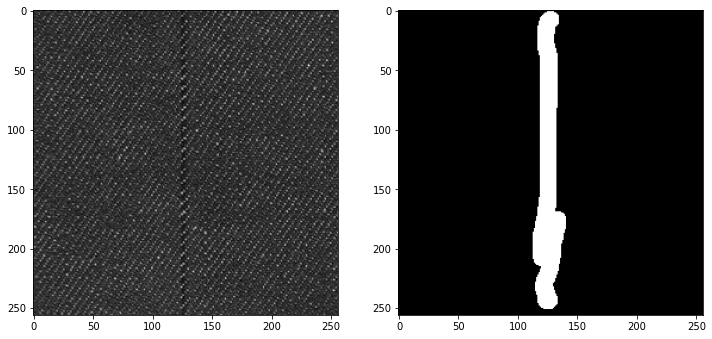

In [34]:
#visualize few images

import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')

plt.show()

In [35]:
IMG_HEIGHT = train_img_data.shape[1]
IMG_WIDTH  = train_img_data.shape[2]
IMG_CHANNELS = train_img_data.shape[3]

In [36]:
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

256
256
1


# Model Building

In [37]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [38]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [40]:
model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [41]:
#initialize our callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = ("defect_febric_segmentation_u_net.h5")
checkpoint = ModelCheckpoint(model_path,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, earlystop]

In [42]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=20,
                    callbacks = callbacks,
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('defect_febric_segmentation_u_net.h5')

Epoch 1/20


2022-07-03 23:43:48.603948: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 79691776 exceeds 10% of free system memory.
2022-07-03 23:43:48.709253: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 79691776 exceeds 10% of free system memory.
2022-07-03 23:43:48.815014: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 79691776 exceeds 10% of free system memory.
2022-07-03 23:43:48.848343: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 79691776 exceeds 10% of free system memory.
2022-07-03 23:43:48.896198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 79691776 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5316
Epoch 00001: val_loss improved from inf to 0.66742, saving model to defect_febric_segmentation_u_net.h5
1/1 [==============================] - 13s 13s/step - loss: 0.6907 - accuracy: 0.5316 - val_loss: 0.6674 - val_accuracy: 0.9562
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.8480
Epoch 00002: val_loss improved from 0.66742 to 0.64872, saving model to defect_febric_segmentation_u_net.h5
1/1 [==============================] - 10s 10s/step - loss: 0.6706 - accuracy: 0.8480 - val_loss: 0.6487 - val_accuracy: 0.9585
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.9085
Epoch 00003: val_loss improved from 0.64872 to 0.62176, saving model to defect_febric_segmentation_u_net.h5
1/1 [==============================] - 9s 9s/step - loss: 0.6517 - accuracy: 0.9085 - val_loss: 0.6218 - val_accuracy: 0.9610
Epoch 4/20
1/1 [=================

# Model Evaluation

In [49]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 441ms/step - loss: 0.0051 - accuracy: 0.9613
Accuracy =  96.13189697265625 %


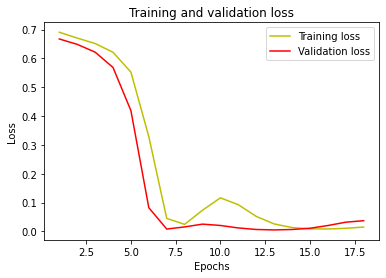

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

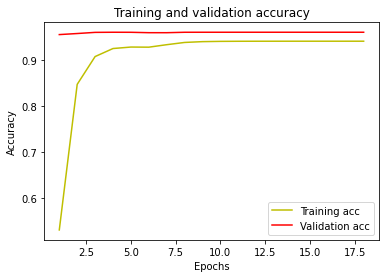

In [51]:
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.0


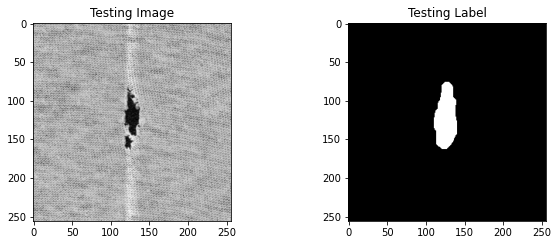

In [53]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')

plt.show()